# Proyecto final - parte 2

In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from PIL import Image
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import backend as k
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Conjunto de datos

In [2]:
def load_image( infilename ) :
    img = Image.open( './distorted_images/' + infilename ).convert('L')
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data

In [3]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir('distorted_images') if isfile(join('distorted_images', f))]

imageDataset = []
index = 0
for imagePath in onlyfiles:
    image = load_image(imagePath)
    imageDataset.append(image)
    index += 1
imageDataset = np.asarray(imageDataset)

In [4]:
dataset2File = "dataset.csv"
dataFrame = pd.read_csv(dataset2File, sep = ';',header = 0)
mos = dataFrame['MOS-STD']

## Preprocesamiento de los datos

(384, 512)
(384, 512)
(384, 512)
(384, 512)
(384, 512)


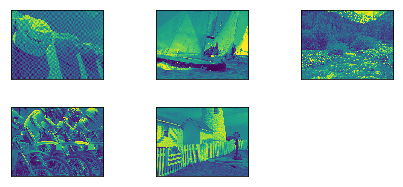

In [5]:
#visualising first 9 data from training dataset

fig = plt.figure()
for i in range(5):
    print(imageDataset[1].shape)
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(imageDataset[i])
    plt.xticks([])
    plt.yticks([])
#fig

In [6]:
#input image size 28*28
img_rows , img_cols = 384, 512

#reshaping
#this assumes our data format
#For 3D data, "channels_last" assumes (conv_dim1, conv_dim2, conv_dim3, channels) while 
#"channels_first" assumes (channels, conv_dim1, conv_dim2, conv_dim3).

if k.image_data_format() == 'channels_first':
    imageDataset = imageDataset.reshape(imageDataset.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    imageDataset = imageDataset.reshape(imageDataset.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

#more reshaping
imageDataset = imageDataset.astype('float32')
imageDataset /= 255
print('imageDataset shape:', imageDataset.shape)
print(imageDataset.shape[0], 'imageDataset samples')

imageDataset shape: (1700, 384, 512, 1)
1700 imageDataset samples


In [7]:
split = train_test_split(mos, imageDataset, test_size=0.25, random_state=42)
(Y_train, Y_test, X_train, X_test) = split

# print number of training, validation, and test images
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

1275 train samples
425 test samples


## Red neuronal CNN

In [8]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))

##model building
model = Sequential()
#convolutional layer with rectified linear unit activation
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
#32 convolution filters used each of size 3x3
#again
model.add(Conv2D(64, (3, 3), activation='relu'))
#64 convolution filters used each of size 3x3
#choose the best features via pooling
model.add(MaxPooling2D(pool_size=(2, 2)))
#randomly turn neurons on and off to improve convergence
model.add(Dropout(0.25))
#flatten since too many dimensions, we only want a classification output
model.add(Flatten())
#fully connected to get all relevant data
model.add(Dense(128, activation='relu'))
#one more dropout for convergence' sake :) 
model.add(Dropout(0.5))
#output a softmax to squash the matrix into output probabilities
model.add(Dense(1, activation='sigmoid'))

# Custom metric of Determination R2
def coeff_determination(y_true, y_pred):
    SS_res =  k.sum(k.square( y_true-y_pred )) 
    SS_tot = k.sum(k.square( y_true - k.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + k.epsilon()) )

#Adaptive learning rate (adaDelta) is a popular form of gradient descent rivaled only by adam and adagrad
#categorical ce since we have multiple classes (10) 
#model.compile(loss='mean_squared_error', optimizer='adam', metrics=[coeff_determination])
model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 382, 510, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 380, 508, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 190, 254, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 190, 254, 64)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3088640)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               395346048 
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

## Entrenamiento del modelo

In [9]:
import time

batch_size = 50
num_epoch = 10

#model training

start = time.time()

model_log = model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=num_epoch,
          verbose=1,
          validation_data=(X_test, Y_test))

end = time.time()
m = (end - start)/60
m = round(m, 2)
s = (end - start)
s = round(s, 2)

print(f"Training time: {m} min / {s} sec")

Train on 1275 samples, validate on 425 samples
Epoch 1/10
1275/1275 [==============================] - 666s 522ms/step - loss: 0.1982 - val_loss: 0.2116
Epoch 2/10
1275/1275 [==============================] - 661s 518ms/step - loss: 0.2042 - val_loss: 0.2116
Epoch 3/10
1275/1275 [==============================] - 667s 523ms/step - loss: 0.2042 - val_loss: 0.2116
Epoch 4/10
1275/1275 [==============================] - 668s 524ms/step - loss: 0.2042 - val_loss: 0.2116
Epoch 5/10
1275/1275 [==============================] - 664s 520ms/step - loss: 0.2042 - val_loss: 0.2116
Epoch 6/10
1275/1275 [==============================] - 662s 519ms/step - loss: 0.2042 - val_loss: 0.2116
Epoch 7/10
1275/1275 [==============================] - 665s 522ms/step - loss: 0.2042 - val_loss: 0.2116
Epoch 8/10
1275/1275 [==============================] - 662s 520ms/step - loss: 0.2042 - val_loss: 0.2116
Epoch 9/10
1275/1275 [==============================] - 667s 523ms/step - loss: 0.2042 - val_loss: 0.2116

## Evaluación del rendimiento del CNN

In [10]:
#how well did it do? 

start = time.time()

score = model.evaluate(X_test, Y_test, verbose=0)

end = time.time()
m = (end - start)/60
m = round(m, 2)
s = (end - start)
s = round(s, 2)
print('Test loss:', score[0])
print('Test accuracy:', score[1]*100, '%')

print(f"Test time: {m} min / {s} sec")

IndexError: invalid index to scalar variable.

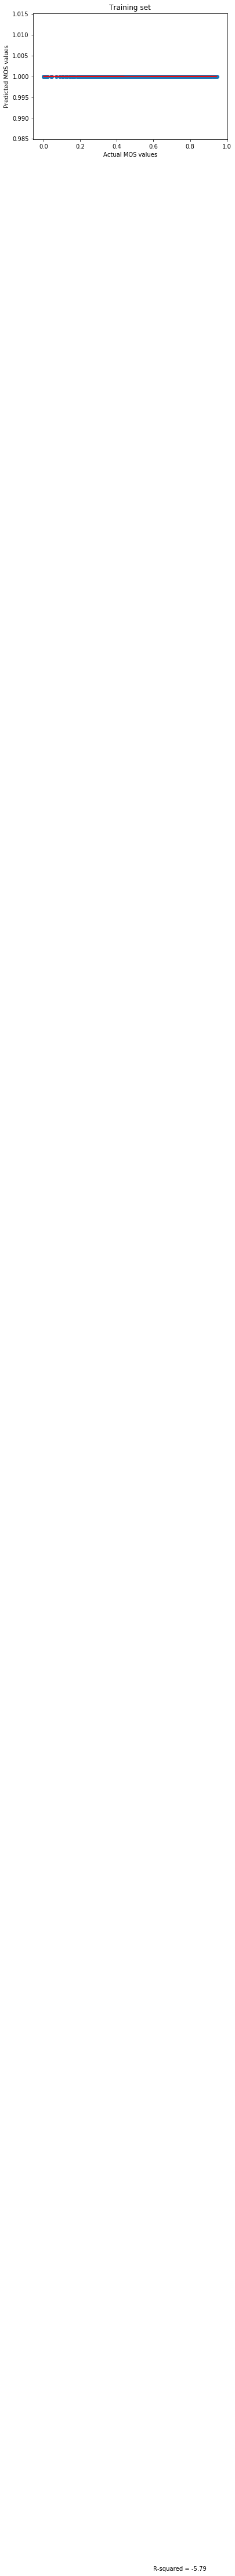

In [ ]:
from sklearn.metrics import r2_score

def plot_metric(group, output, title):
    y_test = output.values
    Y_pred = model.predict(group)

    r_squared = r2_score(y_test, Y_pred)
    plt.scatter(y_test,Y_pred)
    plt.title(title)
    plt.xlabel('Actual MOS values')
    plt.ylabel('Predicted MOS values')

    denominator = y_test.dot(y_test) - y_test.mean() * y_test.sum()
    m = (y_test.dot(Y_pred) - Y_pred.mean() * y_test.sum()) / denominator
    b = (Y_pred.mean() * y_test.dot(y_test) - y_test.mean() * y_test.dot(Y_pred)) / denominator
    y_poly = m*y_test + b
    plt.plot(y_test, y_poly, 'r')

    params = {
        'figure.figsize': (10, 10)
    }
    plt.rcParams.update(params)
    plt.text(0.6, 0.4, 'R-squared = %0.2f' % r_squared)
    plt.show()
    
plot_metric(X_train, Y_train, 'Training set')
plot_metric(X_test, Y_test, 'Testing set')

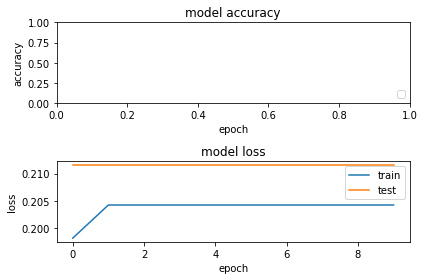

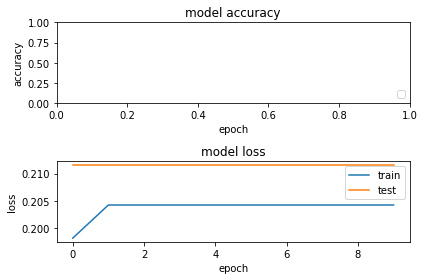

In [13]:
import os
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
#plt.plot(model_log.history['coeff_determination'])
#plt.plot(model_log.history['val_coeff_determination'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(model_log.history['loss'])
plt.plot(model_log.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

fig